<a href="https://colab.research.google.com/github/vinagoros/dv_streamprocessing/blob/main/tp1/ps2022_tp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processamento de Streams 2022
## TP1 - Air Quality Monitoring (airborne particulate matter)
-- version April 6 
 - updated to full dataset.

-- version April 8 
 - added code for spark streaming (unstructured)

-- version April 12
 - added a note to highlight the unstructured data
 format has the timestamp at the last position.




The goal of this project is to analyze data provided by a set of air quality sensors [sds011](https://aqicn.org/sensor/sds011/pt/). The sensors present in the dataset are located in Portugal, namely in the Lisbon metro area. Each sensor provides two values: measuring particles less than 10 µm (P1) and less than 2.5 µm (P2) in μg/m³.

The sensor data, spans the first half of 2020, and is streamed of Kafka. 

Each data sample has the following schema:

sensor_id | sensor_type | location | latitude | longitude | timestamp | P1 | P2
----------|-------------|----------|----------|-----------|-----------|----|---
string  | string | string | float | float| timestamp | float | float



## Questions


1. Find the time of day with the poorest air quality, for each location. Updated daily;
2. Find the average air quality, for each location. Updated hourly;
3. Can you show any daily and/or weekly patterns to air quality?;
4. The data covers a period of extensive population confinement due to Covid 19. Can you find a signal in the data showing air quality improvement coinciding with the confinement period?

## Requeriments

1. Solve each question using one of the systems studied in the course.
2. For questions not fully specified, provide your own interpretation, given your own analysis of the data.

## Grading Criteria 

1. Bonus marks will be given for solving questions using more than one system (eg. Spark Unstructured + Spark Structured);
2. Bonus marks will be given if some kind of graphical output is provided to present the results;
3. Grading will also take into account the general clarity of the programming and of the presentation report (notebook).




### Deadline

30th April + 1 day - ***no penalty***

For each day late, ***0.5 / day penalty***. Penalty accumulates until
the grade of the assignment reaches 8.0.

---
### Colab Setup


In [ ]:
#@title Mount Google Drive (Optional)
from google.colab import drive
drive.mount('/content/drive')

In [1]:
#@title Install PySpark
!pip install pyspark findspark --quiet
import findspark
findspark.init()
findspark.find()

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 14.2 MB/s 


'/usr/local/lib/python3.7/dist-packages/pyspark'

In [2]:
#@title Install & Launch Kafka
%%bash
KAFKA_VERSION=3.1.0
KAFKA=kafka_2.13-$KAFKA_VERSION
wget -q -O /tmp/$KAFKA.tgz https://dlcdn.apache.org/kafka/$KAFKA_VERSION/$KAFKA.tgz
tar xfz /tmp/$KAFKA.tgz
wget -q -O $KAFKA/config/server1.properties - https://github.com/smduarte/ps2022/raw/main/colab/server1.properties

UUID=`$KAFKA/bin/kafka-storage.sh random-uuid`
$KAFKA/bin/kafka-storage.sh format -t $UUID -c $KAFKA/config/server1.properties
$KAFKA/bin/kafka-server-start.sh -daemon $KAFKA/config/server1.properties


Formatting /tmp/kraft-combined-logs


### Air quality sensor data publisher
This a small python Kafka client that publishes a continous stream of text lines, obtained from the periodic output of the sensors.

* The Kafka server is accessible @localhost:9092 
* The events are published to the `air_quality` topic
* Events are published 3600x faster than realtime relative to the timestamp


In [3]:
#@title Start Kafka Publisher
%%bash
pip install kafka-python dataclasses --quiet
wget -q -O - https://github.com/smduarte/ps2022/raw/main/colab/kafka-tp1-logsender.tgz | tar xfz - 2> /dev/null

cd kafka-tp1-logsender
nohup python publisher.py --filename 2020-01-06_sds011-pt.csv --topic air_quality  --speedup 3600 2> publisher-error.log > publisher-out.log &

The python code below shows the basics needed to process JSON data from Kafka source using PySpark.

Spark Streaming python documentation is found [here](https://spark.apache.org/docs/latest/api/python/reference/pyspark.streaming.html)

---
#### PySpark Kafka Stream Example


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

def dumpBatchDF(df, epoch_id):
    df.show(20, False)

spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')


schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True),
                     StructField('p2', FloatType(), True)])

lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*')

query = lines \
    .writeStream \
    .outputMode('append') \
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(600)
query.stop()
spark.stop()

In [ ]:
#@title 1. Find the time of day with the poorest air quality, for each location. Updated daily;

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

def dumpBatchDF(df, epoch_id):
    df.show(24, False)

spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')


schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True),
                     StructField('p2', FloatType(), True)])

lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*')

query = lines \
    .writeStream \
    .outputMode('append') \
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(600)
query.stop()
spark.stop()

### Spark Streaming (UnStructured) 

Latest Spark does not support Kafka sources with UnStructured Streaming.

The next cell publishes the dataset using a TCP server, running at port 7777. For this mode, there is no need to install or run Kafka, using the cell above.

The events are played faster than "realtime", at a 3600x speedup, such that 1 hour in terms of dataset timestamps is
sent in 1 second realtime, provided the machine is fast enough. As such, Spark Streaming window functions need to be sized accordingly, since a minibatch of 1 second will be
worth 1 hour of dataset events.

In [4]:
#@title Start Socket-based Publisher
%%bash

git clone https://github.com/smduarte/ps2022.git 2> /dev/null > /dev/null || git -C ps2022 pull
cd ps2022/colab/socket-tp1-logsender/

nohup python publisher.py --filename 2020-01-06_sds011-pt.csv --port 7777  --speedup 3600 2> /tmp/publisher-error.log > /tmp/publisher-out.log &

Each line sample has the following parts separated by blanks:

sensor_id | sensor_type | location | latitude | longitude | P1 | P2 | timestamp 
----------|-------------|----------|----------|-----------|-----------|----|---
string  | string | string | float | float| float | float | timestamp



In [5]:
#@title 1. Find the time of day with the poorest air quality, for each location. Updated daily;
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext

def spec_reducer(value_a,value_b):
  micro_5_a = value_a[1][0]
  micro_5_b = value_b[1][0]
  micro_20_a = value_a[1][1]
  micro_20_b = value_b[1][1]
  timestamp_a = value_a[0]
  timestamp_b = value_b[0]
  if micro_5_a > micro_5_b:
    return (timestamp_a, (micro_20_a, micro_5_a))
  elif micro_5_a < micro_5_b:
    return (timestamp_b, (micro_20_b, micro_5_b))
  else:
    if micro_20_a > micro_20_b:
      return (timestamp_a, (micro_20_a, micro_5_a))
    else:
      return (timestamp_b, (micro_20_b, micro_5_b))

spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

try:
  ssc = StreamingContext(spark.sparkContext, 1)
  lines = ssc.socketTextStream('localhost', 7777) 
  lines = lines.window(23,23).filter(lambda line: len(line)>0) \
    .map(lambda filtered_line : filtered_line.split(" ")) \
    .map(lambda split_line : (split_line[2],(split_line[7],(split_line[5],split_line[6])))) \
    .reduceByKey(spec_reducer)

  lines.pprint()
    
  ssc.start()
  ssc.awaitTermination(49)  
except Exception as err:
  print(err)
ssc.stop()
spark.stop()

-------------------------------------------
Time: 2022-04-30 17:24:15
-------------------------------------------
('10161', ('2020-01-01T20:32:15', ('59.5', '40.8')))
('14857', ('2020-01-01T19:52:29', ('86.63', '45.38')))
('19563', ('2020-01-01T13:17:57', ('9.55', '8.75')))
('13691', ('2020-01-01T18:45:09', ('87.23', '97.07')))
('14858', ('2020-01-01T19:22:21', ('96.1', '66.57')))
('2332', ('2020-01-01T16:26:59', ('91.3', '99.8')))

-------------------------------------------
Time: 2022-04-30 17:24:38
-------------------------------------------
('10161', ('2020-01-02T18:57:40', ('52.13', '81.77')))
('19563', ('2020-01-02T07:07:38', ('76.82', '85.22')))
('14857', ('2020-01-02T17:54:35', ('39.65', '92.9')))
('13691', ('2020-01-02T13:31:27', ('7.17', '8.63')))
('14858', ('2020-01-02T18:56:59', ('96.97', '164.77')))
('2332', ('2020-01-02T05:20:48', ('78.1', '46.87')))



In [ ]:
#@title 2. Find the average air quality, for each location. Updated hourly;
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext

"""def spec_reducer(value_a,value_b):
  micro_5_a = value_a[1][0]
  micro_5_b = value_b[1][0]
  micro_20_a = value_a[1][1]
  micro_20_b = value_b[1][1]
  timestamp_a = value_a[0]
  timestamp_b = value_b[0]
  if micro_5_a > micro_5_b:
    return (timestamp_a, (micro_20_a, micro_5_a))
  elif micro_5_a < micro_5_b:
    return (timestamp_b, (micro_20_b, micro_5_b))
  else:
    if micro_20_a > micro_20_b:
      return (timestamp_a, (micro_20_a, micro_5_a))
    else:
      return (timestamp_b, (micro_20_b, micro_5_b))
"""

spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()


try:
  ssc = StreamingContext(spark.sparkContext, 1)
  lines = ssc.socketTextStream('localhost', 7777) 
  lines = lines.window(24,24).filter(lambda line: len(line)>0) \
    .map(lambda filtered_line : filtered_line.split(" ")) \
    .map(lambda split_line : (split_line[2],((float(split_line[5]),float(split_line[6]), 1)))) \
    .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1], a[2]+b[2])) \
    .map(lambda line: (line[0],line[1][0]/line[1][2],line[1][1]/line[1][2]))

  lines.pprint()
    
  ssc.start()
  ssc.awaitTermination(49)  
except Exception as err:
  print(err)
ssc.stop()
spark.stop()

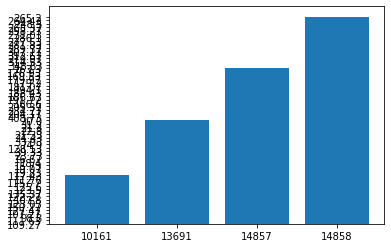

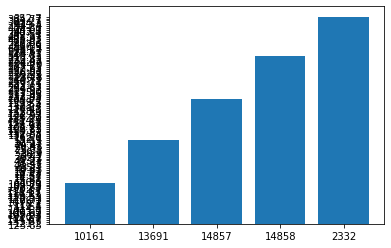

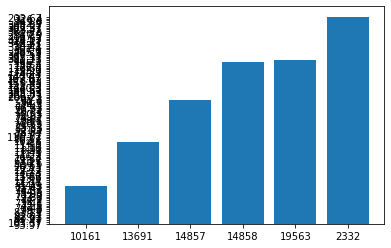

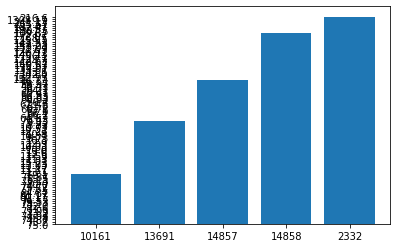

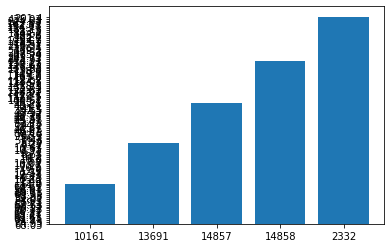

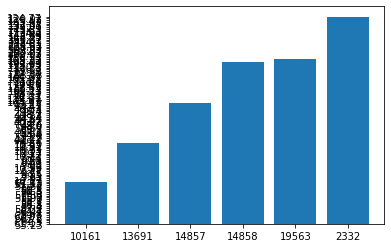

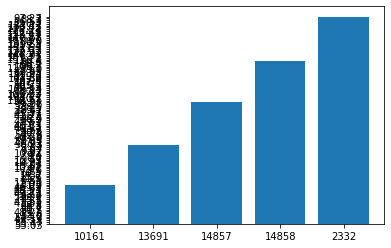

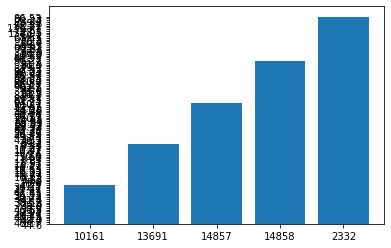

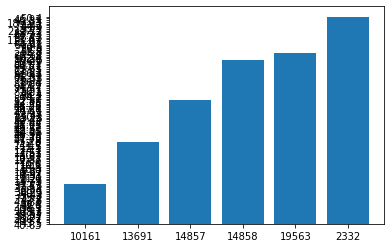

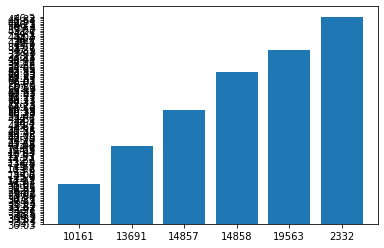

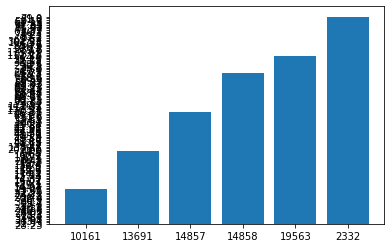

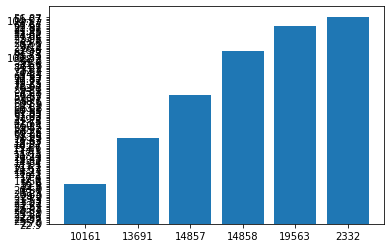

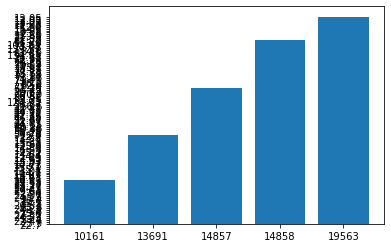

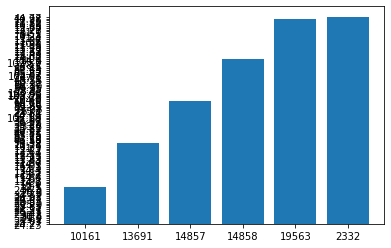

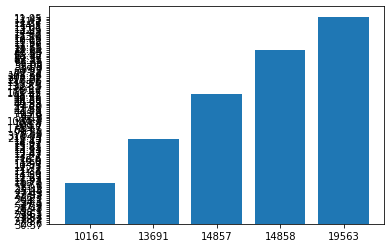

In [43]:
#@title 3.Can you show any daily and/or weekly patterns to air quality?;

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from matplotlib import pyplot as plt
import numpy as np


def plot_rdd(rdd):
  sorted_rdd = rdd.sortBy(lambda keyvalue : keyvalue[0])
  a = np.array(sorted_rdd.collect())
  b = a[:,2]
  a = a[:,0]
  plt.bar(a,b)
  plt.show()

def histogram_rdd(rdd):
  rdd.histogram(6)



spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()


try:
  ssc = StreamingContext(spark.sparkContext, 1)
  lines = ssc.socketTextStream('localhost', 7777) 
  lines = lines.window(1,1).filter(lambda line: len(line)>0) \
    .map(lambda filtered_line : filtered_line.split(" ")) \
    .map(lambda split_line : (split_line[2],split_line[7][0:9],float(split_line[5]),float(split_line[6]))) \
    .foreachRDD(plot_rdd)
    
  ssc.start()
  ssc.awaitTermination(49)  

except Exception as err:
  print(err)

ssc.stop()
spark.stop()
